In [1]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
from planet import tools
import functools
import os
import sys
from scipy import stats
from collections import OrderedDict
import seaborn as sns
import multiprocessing
import time
import pandas as pd
%matplotlib inline

/home/zixuanhu/anaconda3/envs/tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/zixuanhu/anaconda3/envs/tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/zixuanhu/anaconda3/envs/tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/zixuanhu/anaconda3/envs/tf1/lib/python3.6/s


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
# methods={'baseline3': '001' , 'resample_traj4': '002'}
methods={'baseline3': '005' , 'aug7': '003'}
# methods={'baseline3': '005' , 'resample_traj4': '003'}
# methods={'baseline3': '005' , 'aug9': '001'}
env = 'finger_spin'
# env = 'cheetah_run'
# env = 'reacher_easy'
PALETTE = 10 * (
    '#377eb8', '#4daf4a', '#984ea3', '#e41a1c', '#ff7f00', '#a65628',
    '#f781bf', '#888888', '#a6cee3', '#b2df8a', '#cab2d6', '#fb9a99',
    '#fdbf6f')
buffers = OrderedDict()
# for k,v in methods.items():
#     print('Load the trajs of ', k)
#     buffers[k] = np.load(os.path.join('benchmark', env, k,v,'cem_traj.npy'))
#     print(buffers[k].shape)

In [3]:
env = 'finger_spin'
base = 'baseline3'
load_p = 'benchmark/{}/{}/00{}/cem_traj.npy'
buffers[base] = np.concatenate([np.load(load_p.format(env, base, i+1)) for i in range(5)])
buffers['aug7'] = np.concatenate([np.load(load_p.format(env, 'aug7', i+1)) for i in range(5)])


In [4]:
buffers[base].shape

(24810, 1000, 2)

In [5]:

def stratify_by_iter(trajs, part_s=3):
    num_parts = int(np.ceil(10 / part_s))
    num_iters = trajs.shape[0]
    itr = np.arange(num_iters) % 10
    batch = {}
    prev = np.zeros_like(itr)
    for i in range(num_parts):
        select = (itr < (i + 1) * part_s).astype(int)
        pure_select = select - prev
        batch['{}'.format(i * part_s)] = trajs[pure_select.astype(bool)]
        prev = select
    return batch

def horizon_sum(input, horizon=12):
    partial_input = input[:, :, :horizon, :]
    horizon_sum = np.sum(partial_input, axis=2)
    return horizon_sum

def data_stats(data, name):
    return [np.nanmean(data), np.nanstd(data)]


In [6]:

def proposals_diagnostic(trajs, pref=None, plot=False):
    hor_trajs = horizon_sum(trajs, 12)  # N*1000*2
    hor_gts = hor_trajs[:, :, 0]
    hor_preds = hor_trajs[:, :, 1]
    k = 100
    acc_topk, score_gt, score_pred, mean_ratio, rela_acc, cstr_acc, rank_loss = [0.0] * 7
    corres_pred_ranks = []
    print(trajs.shape, hor_trajs.shape)

    num = trajs.shape[0]
    for i, (gt, pred) in enumerate(zip(hor_gts, hor_preds)):

        gt_ind = np.argsort(gt)
        pred_ind = np.argsort(pred)
        top_gt_ind = gt_ind[-k:]
        top_pred_ind = pred_ind[-k:]
        acc_topk += np.intersect1d(top_gt_ind, top_pred_ind).shape[0] / num  # top 100 indices

        score_gt += gt[top_gt_ind].mean() / num
        score_pred += gt[top_pred_ind].mean() / num
        mean_ratio += score_gt / score_pred / num

        gt, pred = gt[gt_ind], pred[gt_ind]
        gt, pred = gt.reshape(-1, 1), pred.reshape(-1, 1)
        gt_diff = gt - gt.T
        pred_diff = pred - pred.T
        geq = gt_diff > 0
#         tgt_posi_dif = np.where(geq, gt_diff, -gt_diff)
#         pred_posi_dif = np.where(geq, pred_diff, -pred_diff)
        tgt_posi_dif = upper_tri_masking(np.where(geq, gt_diff, -gt_diff))
        pred_posi_dif = upper_tri_masking(np.where(geq, pred_diff, -pred_diff))

#         rela_acc += np.mean((tgt_posi_dif > 0) == (pred_posi_dif > 0)) / num
        rela_acc += old_rank( gt, pred)/num
        cstr_acc += np.mean(tgt_posi_dif - pred_posi_dif < 0.0) * 100 / num
        rank_loss += np.maximum(0.0, tgt_posi_dif - pred_posi_dif).mean() / num
        # error = np.abs(gt_diff<0).sum()

        # print(error)
        # assert(error==0)

        pred_rank = np.zeros_like(pred_ind)
        pred_rank[pred_ind] = np.arange(pred_ind.shape[0])
        corres_pred_ranks.append(np.array([pred_rank[j] for j in gt_ind]))
#         if i < 2 and plot:
#             plt.scatter(np.arange(corres_pred_ranks[-1].shape[0]), corres_pred_ranks[-1])
#             plt.savefig(os.path.join(OUT_DIR, pref + '_sample%d_rank.png' % i))
#             plt.cla()

    corres_pred_rank = np.stack(corres_pred_ranks).mean(axis=0)

    results = {'acc_topk': acc_topk, 'score_gt': score_gt, 'score_pred': score_pred, 'mean_ratio': mean_ratio,
               'rela_acc': rela_acc, 'cstr_acc': cstr_acc, 'rank_loss': rank_loss,
               # 'corres_pred_rank': corres_pred_rank,
               'traj_return_gt': data_stats(hor_gts, ' Ground truth reward'),
               'traj_return_pred': data_stats(hor_preds, ' Predicted reward')}
    #print(results['traj_return_gd'],results['traj_return_pred'])
    print(results)
    return results


def planning_diagnostic(buffer):
    # (N, 1000, 12, 2)
    traj_list = stratify_by_iter(buffer, 10)
    results = tools.nested.map(proposals_diagnostic, traj_list)

    merged = {
              k: np.array([v[k] for v in results.values()])
              for k in results['0'].keys()
              }
    print(merged)
    return merged

In [7]:
metrics = ['acc_topk', 'avgRank_topk_by_pred', 'avgRank_topk_by_gt','score_gt', 'score_pred', 'mean_ratio', 'rela_acc_all', 'cstr_acc_all', 'rank_loss_all', 
           'rela_acc_lowm', 'cstr_acc_lowm', 'rank_loss_lowm','rela_acc_midm', 'cstr_acc_midm', 'rank_loss_midm', 'rela_acc_highr', 'cstr_acc_highr', 'rank_loss_highr',
          'rela_acc_lowr', 'cstr_acc_lowr', 'rank_loss_lowr','traj_return_gt','traj_return_pred']
def ranking_full(gt_sort_ind, pred_sort_ind):
    counter=0
    within_gd=np.zeros_like(gt_sort_ind)
    within_pred=np.zeros_like(gt_sort_ind)
    l = gt_sort_ind.shape[0]
    results = []
    for i, (gd, pred) in enumerate(zip(gt_sort_ind, pred_sort_ind)):
        if gd==pred:
            counter+=1
        else:
            if within_pred[gd]==1:
                counter+=1
            if within_gd[pred]==1:
                counter+=1
        within_gd[gd]=1
        within_pred[pred]=1
        results.append(counter/(i+1)*100)
    return np.array(results)
def upper_tri_masking(A):
    m,n = A.shape[:2]
    r = np.arange(m)
    c = np.arange(n)
    mask = r[:, None] < c
#     print(r, mask)
    return A[mask]

def get_rela_acc(gt1, pred1, gt2=None, pred2=None, margin_stra=False):
    gt1, pred1 = gt1.reshape(-1, 1), pred1.reshape(-1, 1)
    gt_diff = gt1 - gt1.T if gt2 is None else gt1 - gt2.reshape(1, -1)
    pred_diff = pred1 - pred1.T if pred2 is None else pred1- pred2.reshape(1, -1)
    geq = gt_diff > 0
    tgt_posi_dif = np.where(geq, gt_diff, -gt_diff)
    pred_posi_dif = np.where(geq, pred_diff, -pred_diff)
    
    tgt_posi_dif = upper_tri_masking(tgt_posi_dif)
    pred_posi_dif = upper_tri_masking(pred_posi_dif)
    def do_compute(slt_tgt_diff, slt_pred_diff):
        rela_acc = np.mean(slt_pred_diff>=0)*100
        cstr_acc = np.mean(slt_tgt_diff - slt_pred_diff <= 0.0) * 100 
        rank_loss = np.maximum(0.0, slt_tgt_diff - slt_pred_diff).mean()
        return rela_acc, cstr_acc, rank_loss
    
    rela_acc_all, cstr_acc_all, rank_loss_all = do_compute(tgt_posi_dif, pred_posi_dif)
    if not margin_stra:
        return rela_acc_all, cstr_acc_all, rank_loss_all
    tgt_posi_dif, pred_posi_dif = tgt_posi_dif.reshape(-1), pred_posi_dif.reshape(-1)
    gt_ind = np.argsort(tgt_posi_dif)
    tgt_posi_dif, pred_posi_dif = tgt_posi_dif[gt_ind], pred_posi_dif[gt_ind]
    
    num = tgt_posi_dif.shape[0]
    rela_acc_lowm, cstr_acc_lowm, rank_loss_lowm = do_compute(tgt_posi_dif[:num//10], pred_posi_dif[:num//10])
#     rela_acc_midm, cstr_acc_midm, rank_loss_midm = do_compute(tgt_posi_dif[:num//5], pred_posi_dif[:num//5])
    rela_acc_midm, cstr_acc_midm, rank_loss_midm = do_compute(tgt_posi_dif[:num//2], pred_posi_dif[:num//2])
    
    return rela_acc_all, cstr_acc_all, rank_loss_all, rela_acc_lowm, cstr_acc_lowm, rank_loss_lowm,rela_acc_midm, cstr_acc_midm, rank_loss_midm
    

def ana(gt1, pred1):
    k=100
    
    # descending
    gt_ind = np.argsort(gt1)[::-1]
    pred_ind = np.argsort(pred1)[::-1]
    
    # Overlapping of top 100 indices
    top_gt_ind = gt_ind[:k]
    top_pred_ind = pred_ind[:k]
    acc_topk = np.intersect1d(top_gt_ind, top_pred_ind).shape[0]  
    
    # trajectories ranking by ground truth return and predicted return
    pred_rank, gt_rank = np.zeros_like(pred_ind), np.zeros_like(pred_ind)
    pred_rank[pred_ind], gt_rank[gt_ind] = np.arange(pred_ind.shape[0]), np.arange(pred_ind.shape[0])
    avgRank_topk_by_pred = pred_rank[top_gt_ind].mean()
    avgRank_topk_by_gt = gt_rank[top_pred_ind].mean()
    
    acc_rank_full = ranking_full(gt_ind, pred_ind)
    assert np.abs(acc_rank_full[k-1]-acc_topk)<1e-5, 'wrong  {}, {}'.format(acc_rank_full[k-1], acc_topk)

    score_gt = gt1[top_gt_ind].mean() 
    score_pred = gt1[top_pred_ind].mean() 
    mean_ratio = 1.0 
       
    gt1 = gt1[gt_ind]
    pred1 = pred1[gt_ind]
    
    rela_acc_all, cstr_acc_all, rank_loss_all, rela_acc_lowm, cstr_acc_lowm, rank_loss_lowm,rela_acc_midm, cstr_acc_midm, rank_loss_midm = get_rela_acc(gt1, pred1, margin_stra=True)
    rela_acc_highr, cstr_acc_highr, rank_loss_highr = get_rela_acc(gt1[:100], pred1[:100], gt1[:], pred1[:])
    rela_acc_lowr, cstr_acc_lowr, rank_loss_lowr = get_rela_acc(gt1[:500], pred1[:500], gt1[:], pred1[:])
    
    traj_return_gt = gt1.mean()
    traj_return_pred = pred1.mean()

    return np.array([acc_topk, avgRank_topk_by_pred, avgRank_topk_by_gt, score_gt, score_pred, mean_ratio, rela_acc_all, cstr_acc_all, rank_loss_all, rela_acc_lowm, cstr_acc_lowm, rank_loss_lowm,rela_acc_midm, cstr_acc_midm, rank_loss_midm,
                     rela_acc_highr, cstr_acc_highr, rank_loss_highr, rela_acc_lowr, cstr_acc_lowr, rank_loss_lowr, traj_return_gt, traj_return_pred]), acc_rank_full
    
    
def proposals_diagnostic2(trajs, pref=None, multi=True):
#     trajs= horizon_sum(trajs)
    hor_gts = trajs[:,:,0]
    hor_preds = trajs[:,:,1]
    k = 100
    batch_data = []
#     print(trajs.shape)
    for hor_gt, hor_pred in zip(hor_gts, hor_preds):
        batch_data.append((hor_gt, hor_pred))
    start_time = time.time()
    if multi:
        pool = multiprocessing.Pool(processes=16)
        bundle = pool.starmap(ana, batch_data)
        pool.close()
    else:
        bundle=[]
        for i,(hor_gt, hor_pred) in enumerate(batch_data):
            bundle.append(ana(hor_gt, hor_pred))
            
    results, full_rank_acc = zip(*bundle)
    
    df = pd.DataFrame(results, columns=metrics)
    
    means = np.stack(results, axis=0).mean(0)
    full_rank_acc = np.stack(full_rank_acc, axis=0).mean(0)
    print('finish')
    final = {k:v for k,v in zip(metrics, means)}
    final['df'] = df
    final['full_rank_acc'] = full_rank_acc
    return final


    
    return batch
def planning_diagnostic2(buffer, s=1, multi=True):
    # (N, 1000, 12, 2)
    traj_list = stratify_by_iter(buffer, s)
    func = functools.partial(proposals_diagnostic2, multi=multi)
    results = tools.nested.map(func, traj_list)
    merged = {
#               k: np.array([v[k] for v in results.values()])
              k: [v[k] for v in results.values()]
              for k in results['0'].keys()
              }
    for i, df in enumerate(merged['df']):
        df['iteration'] = i
    merged['df'] = pd.concat(merged['df'])
#     print(merged)
    return merged

In [8]:
result = OrderedDict()
for method, buffer in buffers.items():
    result[method] = planning_diagnostic2(buffer[:], 1, multi=True)
    result[method]['df']['method'] = method


finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish
finish


In [9]:

def plot_std(results, metric,hor, show=True, col_st=0):
    type = 'hor{}_'.format(hor) + metric
    for i, (name, v) in enumerate(results.items()):
        mean = v[metric][:, 0]
        std = v[metric][:, 1]
        xs = np.arange(mean.shape[0])
        kw = dict(color=PALETTE[i], alpha=0.1, linewidths=0)
        plt.fill_between(xs, mean - std, mean + std, **kw)
        plt.plot(xs, mean, color=PALETTE[i+col_st], label=name+'_'+metric)
        plt.scatter(xs, mean, color=PALETTE[-i-col_st])
    plt.title(type)
    plt.legend()
#     plt.savefig(os.path.join(OUT_DIR, type+ '.png'))
    if show:
        plt.show()
#     plt.clf()


def plot_line(results, metric, hor, show=True, col_st=0):
    for i, (name, v) in enumerate(results.items()):
        ys = v[metric]
        xs = np.arange(len(ys))
        plt.plot(xs, ys, color=PALETTE[i+col_st], label=name+'_'+metric)
        plt.scatter(xs, ys, color=PALETTE[-i-col_st])
    plt.title(type)
    plt.legend()
    if show:
        plt.show()
#     plt.savefig(os.path.join(OUT_DIR, type + '.png'))
#     plt.clf()
def plot_full_ranking(results):
    row,col = 2, 5
    figsize = (4*col, 4*row)
    fig, axs = plt.subplots(row, col, figsize=figsize)
    print('plot_full_ranking')
    for r in range(row):
        for c in range(col):
            msg = ''
            for i, (k, v) in enumerate(results.items()):
                itr=r*col+c
                ys = v['full_rank_acc'][itr]
                msg+='{}: {}  '.format(k, ys.mean())
                xs = np.arange(len(ys))
                axs[r,c].plot(xs, ys, color=PALETTE[i], label=k ) 
                axs[r,c].set_title('CEM iteration {}'.format(itr))
            print(msg)
    plt.legend()
    plt.show()
    
metrics = ['acc_topk', 'avgRank_topk_by_pred', 'avgRank_topk_by_gt','score_gt', 'score_pred', 'mean_ratio', 'rela_acc_all', 'cstr_acc_all', 'rank_loss_all', 
           'rela_acc_lowm', 'cstr_acc_lowm', 'rank_loss_lowm','rela_acc_midm', 'cstr_acc_midm', 'rank_loss_midm', 'rela_acc_highr', 'cstr_acc_highr', 'rank_loss_highr',
          'rela_acc_lowr', 'cstr_acc_lowr', 'rank_loss_lowr']
def plot_all(results, hor):
    
    metrics = next(iter(results.values())).keys()
    df_all = pd.concat([v['df'] for v in results.values()])
    sns.set_theme(style="darkgrid")
    def lineplot(df, x, y, ci=None,show=True, markers=None, label=None, **kwargs):
        sns.lineplot(x=x, y=y, markers=markers, label=label,
                 hue="method", data=df_all,ci=ci, **kwargs)
        if show:
            plt.show()
    plot_full_ranking(results)
    
#     plot_line(results, 'acc_topk', hor)
#     plot_line(results, 'avgRank_topk_by_pred', hor)
#     plot_line(results, 'avgRank_topk_by_gt', hor)
    lineplot(df_all, 'iteration', 'acc_topk', ci='sd')
    lineplot(df_all, 'iteration', 'avgRank_topk_by_pred',ci='sd')
    lineplot(df_all, 'iteration', 'avgRank_topk_by_gt',ci='sd')
    
    plot_line(results, 'score_gt', hor, show=False)
    plot_line(results, 'score_pred', hor, show=True, col_st=2)
    
    plot_line(results, 'rela_acc_all', hor, show=False)
    plot_line(results, 'rela_acc_midm', hor, show=False, col_st=2)
    plot_line(results, 'rela_acc_lowm', hor, col_st=4)
    
    plot_line(results, 'cstr_acc_all', hor, show=False)
    plot_line(results, 'cstr_acc_midm', hor, show=False, col_st=2)
    plot_line(results, 'cstr_acc_lowm', hor, col_st=4)
    
    plot_line(results, 'rank_loss_all', hor, show=False)
    plot_line(results, 'rank_loss_midm', hor, show=False, col_st=2)
    plot_line(results, 'rank_loss_lowm', hor, col_st=4)
    
    plot_line(results, 'rela_acc_all', hor, show=False)
    plot_line(results, 'rela_acc_highr', hor, show=False, col_st=2)
    plot_line(results, 'rela_acc_lowr', hor, col_st=4)
    
    plot_line(results, 'cstr_acc_all', hor, show=False)
    plot_line(results, 'cstr_acc_highr', hor, show=False, col_st=2)
    plot_line(results, 'cstr_acc_lowr', hor, col_st=4)
    
    plot_line(results, 'rank_loss_all', hor, show=False)
    plot_line(results, 'rank_loss_highr', hor, show=False, col_st=2)
    plot_line(results, 'rank_loss_lowr', hor, col_st=4)
    
    plot_std(results, 'traj_return_gt', hor, show=False)
    plot_std(results, 'traj_return_pred', hor, show=False, col_st=2)
    
    
#     for metric in metrics:
#         print('Plot ', metric)
#         if 'traj' not in metric:
#             plot_line(results, metric, hor)
#         else:
#             plot_std(results, metric, hor)

#     plot_std(results, metric, hor)



plot_full_ranking
baseline3: 62.069708288056646  aug7: 63.60408868395951  
baseline3: 60.80201213073389  aug7: 62.72353660772626  
baseline3: 59.239418587963435  aug7: 61.46163495915563  
baseline3: 58.433068160268185  aug7: 60.70083905102745  
baseline3: 57.742275744535426  aug7: 60.04271804441959  
baseline3: 57.19453099565119  aug7: 59.584850627517135  
baseline3: 56.89897765336342  aug7: 59.31987389243927  
baseline3: 56.674588575563035  aug7: 59.132491079798974  
baseline3: 56.461427447639636  aug7: 58.914681906474456  
baseline3: 56.267879462793225  aug7: 58.567175810984665  


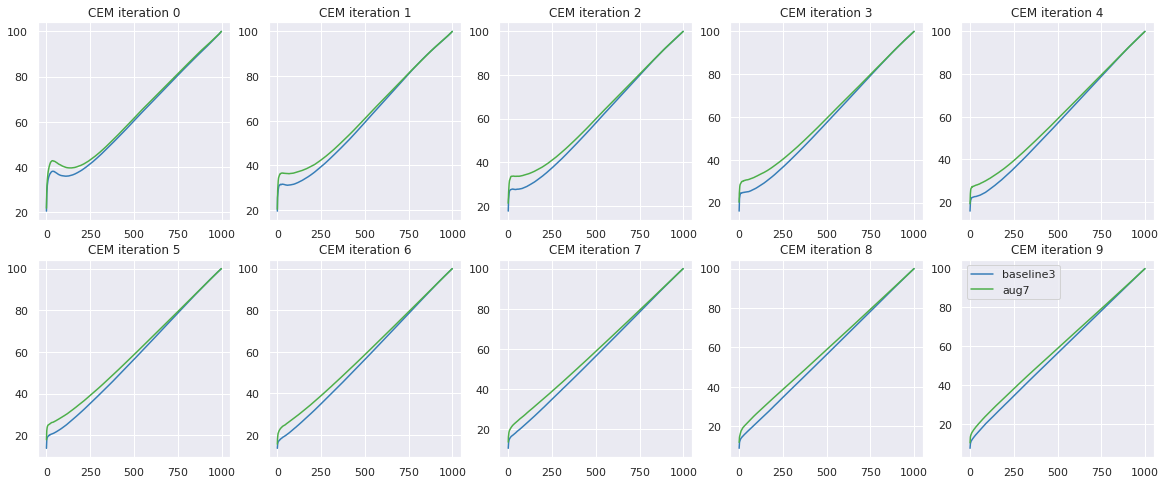

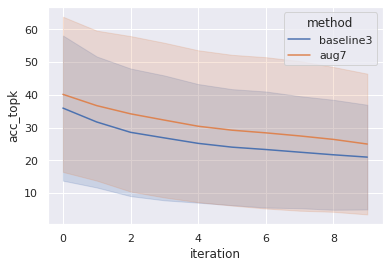

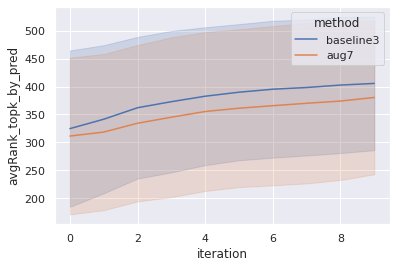

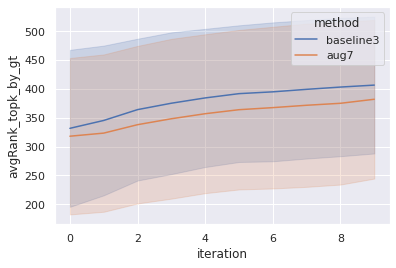

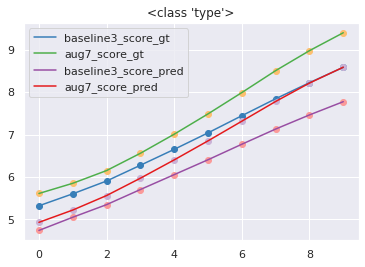

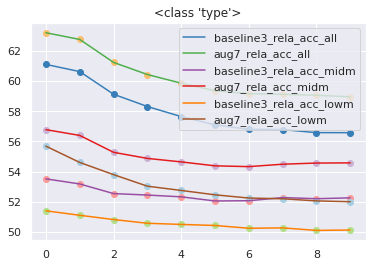

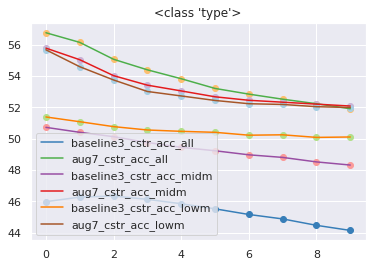

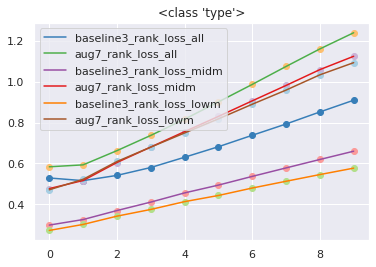

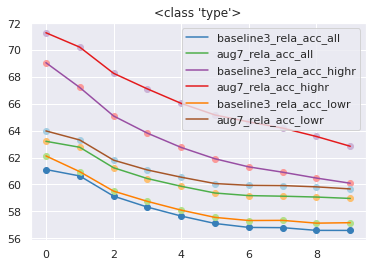

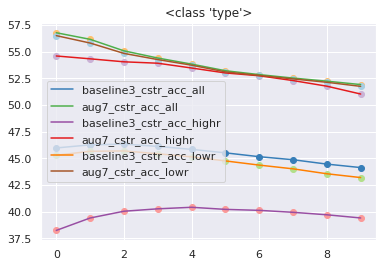

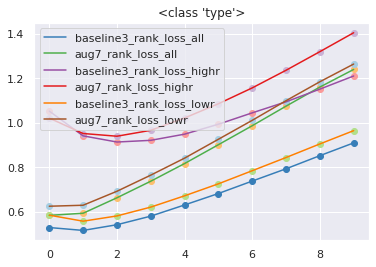

TypeError: list indices must be integers or slices, not tuple

In [10]:
plot_all(result, 12)

In [ ]:
def evaluate(env, base, rival):
    load_p = 'benchmark/{}/{}/00{}/cem_traj.npy'
    buffers[base] = np.concatenate([np.load(load_p.format(env, base, i+1)) for i in range(5)])
    buffers['aug7'] = np.concatenate([np.load(load_p.format(env, rival, i+1)) for i in range(5)])

    

In [44]:
x=np.load('benchmark/finger_spin/baseline3/001/cem_traj.npy')
print(x.shape)

(4840, 1000, 2)


In [45]:
y=np.load('benchmark/finger_spin/aug7/001/onrival.npy')
print(y.shape)

(1971, 10, 1000, 3)


In [39]:
x.shape
y2= y.reshape(-1, 1000,3)[:4840, :,:2]

In [41]:
y2.shape==x.shape

True

In [43]:
np.sum(np.abs(x-y2))

32177158.0

In [59]:
for p in x:
    find= False
    for i in range(4840):
        err = np.sum(np.abs(y2[i]-p))
        if err<1e-6:
            find=True
            break
    if not find:
        print('fk')